# Introduction
In this notebook, you will find code scaffolding for the seq2seq part of Homework 3 (code for the trees section of the assignment is released in another notebook). There are certain parts of the scaffolding marked with `# Your code here!` comments where you can fill in code to perform the specified tasks. After implementing the methods in this notebook, you will need to design and perform experiments to evaluate each method and respond to the questions in the Homework 3 handout (available on Canvas). You should be able to complete this assignment without changing any of the scaffolding code, just writing code to fill in the scaffolding and run experiments.

# Set up dependencies and data

In [139]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
rm -rf hw3

# hopefully will work when no longer private...
# git clone https://github.com/mit-6864/hw3.git

pip install sacrebleu

In [140]:
!mkdir -p /content/hw3/data

In [141]:
!ls


hw3  sample_data


In [159]:
import sys
sys.path.append("/content/hw3")

import lab_utils

import importlib
importlib.reload(lab_utils)
dir(lab_utils)

import torch 
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
assert device == "cuda"   # use gpu whenever you can!

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Part 1: Sequence-to-Sequence Model

In this lab, we will explore RNN-based sequence-to-sequence (seq2seq) models to perform machine translation (MT).

*   **Task:** translate from Vietnamese to English
*   **Model:** RNN-based encoder-decoder
*   **Data:** Vietnamese-English dataset from IWSLT'15


Implementation Tasks:
1. Data Preprocessing (done by TAs)
2. **Encoder** 
3. **Decoder**
4. Vanilla EncoderDecoder (done by TAs)
5. Generator (done by TAs)
6. **Attention Layer** (should we choose mechanism or let them choose?)
7. **Attention-based Decoder**
8. **EncoderAttentionDecoder** - basically can copy Vanilla
9. Training (done by TAs)
10. **Greedy Decoding** 
11. ***Beam Decoding (6.806 optional)***
12. **Written/Thinking: Analyze Decoded Output**
13. Testing via BLEU (done by TAs)

## Section 1: Data Preprocessing

No need to write any code in this section. But you are encouraged to test with this part to understand the data.



### Download data
First, we download the dataset and put it in the `/content/hw3/data` folder.

In [143]:
# Download data
DATA_DIR = "/content/hw3/data"

!wget -nv -O "$DATA_DIR/train.en" https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.en
!wget -nv -O "$DATA_DIR/train.vi" https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.vi
!wget -nv -O "$DATA_DIR/tst2013.en" https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.en
!wget -nv -O "$DATA_DIR/tst2013.vi" https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.vi
!wget -nv -O "$DATA_DIR/vocab.en" https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.en
!wget -nv -O "$DATA_DIR/vocab.vi" https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.vi


2021-02-23 03:10:21 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.en [13603614/13603614] -> "/content/hw3/data/train.en" [1]
2021-02-23 03:10:40 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.vi [18074646/18074646] -> "/content/hw3/data/train.vi" [1]
2021-02-23 03:10:42 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.en [132264/132264] -> "/content/hw3/data/tst2013.en" [1]
2021-02-23 03:10:43 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.vi [183855/183855] -> "/content/hw3/data/tst2013.vi" [1]
2021-02-23 03:10:45 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.en [139741/139741] -> "/content/hw3/data/vocab.en" [1]
2021-02-23 03:10:46 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.vi [46767/46767] -> "/content/hw3/data/vocab.vi" [1]


### Load the Data and Preprocess
We then load the sentences and vocab lists, only keeping sentences that do not exceed 48 words (50 with the EOS tags).

Number of training (src, trg) sentence pairs: 108748
Number of validation (src, trg) sentence pairs: 12083
Number of testing (src, trg) sentence pairs: 1139
Size of en vocab set (including '<pad>', '<unk>', '<s>', '</s>'): 7710
Size of vi vocab set (including '<pad>', '<unk>', '<s>', '</s>'): 17192
Training sentence avg. length: 20 
Training sentence length at 95-percentile: 42
Training sentence length distribution (x-axis is length range and y-axis is count):



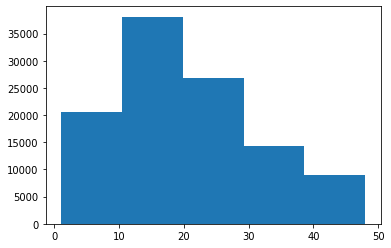

Example Vietnamese input: ['Adam', 'Sadowsky', 'dàn', 'dựng', '1', 'video', 'âm', 'nhạc', 'hiện', 'tượng', '.']
Its target English output: ['Adam', 'Sadowsky', ':', 'How', 'to', 'engineer', 'a', 'viral', 'music', 'video']


In [144]:
from lab_utils import read_vocab_file, read_sentence_file, filter_data, show_some_data_stats

src_vocab_set = read_vocab_file("vocab.vi")
trg_vocab_set = read_vocab_file("vocab.en")

train_src_sentences_list = read_sentence_file("train.vi")
train_trg_sentences_list = read_sentence_file("train.en")
assert len(train_src_sentences_list) == len(train_trg_sentences_list)

test_src_sentences_list = read_sentence_file("tst2013.vi")
test_trg_sentences_list = read_sentence_file("tst2013.en")
assert len(test_src_sentences_list) == len(test_trg_sentences_list)

# Filter out sentences over 48 words long
MAX_SENT_LENGTH = 48
MAX_SENT_LENGTH_PLUS_SOS_EOS = 50

train_src_sentences_list, train_trg_sentences_list = filter_data(
    train_src_sentences_list, train_trg_sentences_list, MAX_SENT_LENGTH)
test_src_sentences_list, test_trg_sentences_list = filter_data(
    test_src_sentences_list, test_trg_sentences_list, MAX_SENT_LENGTH)

# We take 10% of training data as validation set.
num_val = int(len(train_src_sentences_list) * 0.1)
val_src_sentences_list = train_src_sentences_list[:num_val]
val_trg_sentences_list = train_trg_sentences_list[:num_val]
train_src_sentences_list = train_src_sentences_list[num_val:]
train_trg_sentences_list = train_trg_sentences_list[num_val:]

show_some_data_stats(train_src_sentences_list, val_src_sentences_list, 
                     test_src_sentences_list, train_trg_sentences_list,
                     src_vocab_set, trg_vocab_set)

## **Section 2: Encoder**

First, here is the Dataset. The IDs that we reserve might be useful later.

In [145]:
import torch
from torch.utils import data

# These IDs are reserved.
##TODO ABBY __ OFF BY ONE ERROR< ADD PAD TO VOCABS! LINE ZEOR
PAD_INDEX = 0
UNK_INDEX = 1
SOS_INDEX = 2
EOS_INDEX = 3


class MTDataset(data.Dataset):
  def __init__(self, src_sentences, src_vocabs, trg_sentences, trg_vocabs,
               sampling=1.):
    self.src_sentences = src_sentences[:int(len(src_sentences) * sampling)]
    self.trg_sentences = trg_sentences[:int(len(src_sentences) * sampling)]

    self.max_src_seq_length = MAX_SENT_LENGTH_PLUS_SOS_EOS
    self.max_trg_seq_length = MAX_SENT_LENGTH_PLUS_SOS_EOS

    self.src_vocabs = src_vocabs
    self.trg_vocabs = trg_vocabs

    self.src_v2id = {v : i for i, v in enumerate(src_vocabs)}
    self.src_id2v = {val : key for key, val in self.src_v2id.items()}
    self.trg_v2id = {v : i for i, v in enumerate(trg_vocabs)}
    self.trg_id2v = {val : key for key, val in self.trg_v2id.items()}

  def __len__(self):
    return len(self.src_sentences)

  def __getitem__(self, index):
    src_sent = self.src_sentences[index]
    src_len = len(src_sent) + 2   # add <s> and </s> to each sentence
    src_id = []
    for w in src_sent:
      if w not in self.src_vocabs:
        w = '<unk>'
      src_id.append(self.src_v2id[w])
    src_id = ([SOS_INDEX] + src_id + [EOS_INDEX] + [PAD_INDEX] *
              (self.max_src_seq_length - src_len))

    trg_sent = self.trg_sentences[index]
    trg_len = len(trg_sent) + 2
    trg_id = []
    for w in trg_sent:
      if w not in self.trg_vocabs:
        w = '<unk>'
      trg_id.append(self.trg_v2id[w])
    trg_id = ([SOS_INDEX] + trg_id + [EOS_INDEX] + [PAD_INDEX] *
              (self.max_trg_seq_length - trg_len))

    return torch.tensor(src_id), src_len, torch.tensor(trg_id), trg_len


Seq2seq consists of an Encoder RNN and a Decoder RNN. In a vanilla seq2seq model where there is no attention mechanism between encoder and decoder, the encoder aims to compress the information contained in the entire input sequence into a single vector and pass it to decoder.

We start with implementing the encoder, which is just a simple RNN. We use a GRU here, but feel free to try other cell types.

In [146]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class Encoder(nn.Module):
  def __init__(self, input_size, hidden_size, dropout=0.):
    """
    Inputs: 
      - `input_size`: an int representing the RNN input size.
      - `hidden_size`: an int representing the RNN hidden size.
      - `dropout`: a float representing the dropout rate during training. Note
          that for 1-layer RNN this has no effect since dropout only applies to
          outputs of intermediate layers.
    """
    
    super(Encoder, self).__init__()

    self.rnn = nn.GRU(input_size, hidden_size, num_layers=1, batch_first=True,
                      dropout=dropout, bidirectional=False)

  def forward(self, inputs, lengths):
    """
    Inputs:
      - `inputs`: a 3d-tensor of shape (batch_size, max_seq_length, embed_size)
          representing a batch of padded embedded word vectors of source
          sentences.
      - `lengths`: a 1d-tensor of shape (batch_size,) representing the sequence
          lengths of `inputs`.

    Returns:
      - `outputs`: a 3d-tensor of shape
        (batch_size, max_seq_length, hidden_size).
      - `finals`: a 3d-tensor of shape (num_layers, batch_size, hidden_size).
      Hint: `outputs` and `finals` are both standard GRU outputs. Check:
      https://pytorch.org/docs/stable/nn.html#gru
    """
    outputs = None
    finals = None
    
    # --------- Your code here --------- #
    packed = pack_padded_sequence(inputs, lengths.cpu(), batch_first=True,
                                  enforce_sorted=False)
    outputs, finals = self.rnn(packed)
    outputs, _ = pad_packed_sequence(outputs, batch_first=True,
                                     total_length=MAX_SENT_LENGTH_PLUS_SOS_EOS)
    # --------- Your code ends --------- #

    return outputs, finals

## **Section 3: Decoder**

Here you will implement a decoder RNN that uses encoder's last hidden state to initialize its initial hidden state.

In [147]:
class Decoder(nn.Module):
  """An RNN decoder without attention."""

  def __init__(self, input_size, hidden_size, dropout=0.):
    """
      Inputs:
        - `input_size`, `hidden_size`, and `dropout` the same as in Encoder.
    """
    super(Decoder, self).__init__()

    # --------- Your code here --------- #
    self.rnn = nn.GRU(input_size, hidden_size, batch_first=True,
                      dropout=dropout)

    # To initialize from the final encoder state.
    self.bridge = nn.Linear(hidden_size, hidden_size, bias=True)

    self.dropout_layer = nn.Dropout(p=dropout)
    self.pre_output_layer = nn.Linear(hidden_size + input_size, hidden_size,
                                      bias=False)
    # --------- Your code ends --------- #

  def forward_step(self, prev_embed, hidden):
    """Perform a single decoder step (1 word)."""

    # Update RNN hidden state.
    output, hidden = self.rnn(prev_embed, hidden)

    pre_output = torch.cat([prev_embed, output], dim=2)

    pre_output = self.dropout_layer(pre_output)
    pre_output = self.pre_output_layer(pre_output)

    return output, hidden, pre_output

  def forward(self, inputs, encoder_finals, hidden=None, max_len=None):
    """Unroll the decoder one step at a time.

    Inputs:
      - `inputs`: a 3d-tensor of shape (batch_size, max_seq_length, embed_size)
          representing a batch of padded embedded word vectors of target
          sentences (for teacher-forcing during training).
      - `encoder_finals`: a 3d-tensor of shape
          (num_enc_layers, batch_size, hidden_size) representing the final
          encoder hidden states used to initialize the initial decoder hidden
          states.
      - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size) representing
          the value to be used to initialize the initial decoder hidden states.
          If None, then use `encoder_finals`.
      - `max_len`: an int representing the maximum decoding length.

    Returns:
      - `outputs`: a 3d-tensor of shape
          (batch_size, max_seq_length, hidden_size) representing the raw
          decoder outputs (before converting to a `trg_vocab_size`-dim vector).
          We will convert it later in a `Generator` below.
      - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size)
          representing the last decoder hidden state.
    """

    # The maximum number of steps to unroll the RNN.
    if max_len is None:
      max_len = inputs.size(1)

    # Initialize decoder hidden state.
    if hidden is None:
      hidden = self.init_hidden(encoder_finals)

    outputs = None
    
    # --------- Your code ends --------- #
    # Here we store all intermediate hidden states and pre-output vectors.
    decoder_states = []
    pre_output_vectors = []

    # Unroll the decoder RNN for `max_len` steps.
    for i in range(max_len):
      prev_embed = inputs[:, i].unsqueeze(1)
      output, hidden, pre_output = self.forward_step(prev_embed, hidden)
      decoder_states.append(output)
      pre_output_vectors.append(pre_output)

    decoder_states = torch.cat(decoder_states, dim=1)
    outputs = torch.cat(pre_output_vectors, dim=1)
    # --------- Your code ends --------- #

    return hidden, outputs

  def init_hidden(self, encoder_finals):
    """Use encoder final hidden state to initialize decoder's first hidden
    state."""
    decoder_init_hiddens = None

    # --------- Your code here (hint: only one line needed) --------- #
    decoder_init_hiddens = torch.tanh(self.bridge(encoder_finals))
    # --------- Your code ends --------- #

    return decoder_init_hiddens

Define the high level encoder-decoder class to wrap up sub-models, including encoder, decoder, generator, and src/trg embeddings.

In [148]:
class EncoderDecoder(nn.Module):
  """A standard Encoder-Decoder architecture without attention.
  """
  def __init__(self, encoder, decoder, src_embed, trg_embed, generator):
    """
    Inputs:
      - `encoder`: an `Encoder` object.
      - `decoder`: a `Decoder` object.
      - `src_embed`: an nn.Embedding object representing the lookup table for
          input (source) sentences.
      - `trg_embed`: an nn.Embedding object representing the lookup table for
          output (target) sentences.
      - `generator`: a `Generator` object. Essentially a linear mapping. See
          the next code cell.
    """
    super(EncoderDecoder, self).__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.trg_embed = trg_embed
    self.generator = generator

  def forward(self, src_ids, trg_ids, src_lengths):
    """Take in and process masked source and target sequences.

    Inputs:
      `src_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
        a batch of source sentences of word ids.
      `trg_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
        a batch of target sentences of word ids.
      `src_lengths`: a 1d-tensor of shape (batch_size,) representing the
        sequence length of `src_ids`.

    Returns the decoder outputs, see the above cell.
    """
    encoder_hiddens, encoder_finals = self.encode(src_ids, src_lengths)
    del encoder_hiddens   # unused
    return self.decode(encoder_finals, trg_ids[:, :-1])

  def encode(self, src_ids, src_lengths):
    return self.encoder(self.src_embed(src_ids), src_lengths)
    
  def decode(self, encoder_finals, trg_ids, decoder_hidden=None):
    return self.decoder(self.trg_embed(trg_ids), encoder_finals, decoder_hidden)

It simply projects the pre-output layer (x in the forward function below) to obtain the output layer, so that the final dimension is the target vocabulary size.

In [149]:
class Generator(nn.Module):
  """Define standard linear + softmax generation step."""
  def __init__(self, hidden_size, vocab_size):
    super(Generator, self).__init__()
    self.proj = nn.Linear(hidden_size, vocab_size, bias=False)

  def forward(self, x):
    return F.log_softmax(self.proj(x), dim=-1)

## **Section 4: Attention-Based Decoder**

Now it's time to add some attention to the decoder. We make the classes again.


In [150]:
class AttentionDecoder(nn.Module):
  """An attention-based RNN decoder."""

  def __init__(self, input_size, hidden_size, attention=None, dropout=0.):
    """
      Inputs:
        - `input_size`, `hidden_size`, and `dropout` the same as in Encoder.
        - `attention`: this is your self-defined Attention object. You can
            either define an individual class for your Attention and pass it
            here or leave `attention` as None and just implement everything
            here.
    """
    super(AttentionDecoder, self).__init__()

    # --------- Your code ends --------- #
    self.attention = attention

    self.rnn = nn.GRU(input_size + hidden_size, hidden_size, batch_first=True,
                      dropout=dropout)

    # To initialize from the final encoder state.
    self.bridge = nn.Linear(hidden_size, hidden_size, bias=True)

    self.dropout_layer = nn.Dropout(p=dropout)
    self.pre_output_layer = nn.Linear(hidden_size + hidden_size + input_size,
                                      hidden_size, bias=False)
    # --------- Your code ends --------- #

  ## START ANSWER // PART OF ANSWER BELOW
  def forward_step(self, prev_embed, encoder_hidden, src_mask, proj_key,
                   hidden):
    """Perform a single decoder step (1 word)"""

    # Compute context vector using attention mechanism.
    query = hidden[-1].unsqueeze(1)

    context, attn_probs = self.attention(query=query, proj_key=proj_key,
                                         value=encoder_hidden, mask=src_mask)

    # Update RNN hidden state.
    rnn_input = torch.cat([prev_embed, context], dim=2)
    output, hidden = self.rnn(rnn_input, hidden)

    pre_output = torch.cat([prev_embed, output, context], dim=2)

    pre_output = self.dropout_layer(pre_output)
    pre_output = self.pre_output_layer(pre_output)

    return output, hidden, pre_output
  ## END ANSWER

  def forward(self, inputs, encoder_hiddens, encoder_finals,  src_mask,
              trg_mask, hidden=None, max_len=None):
    """Unroll the decoder one step at a time.
    
    Inputs:
      - `inputs`: a 3d-tensor of shape (batch_size, max_seq_length, embed_size)
          representing a batch of padded embedded word vectors of target
          sentences (for teacher-forcing during training).
      - `encoder_hiddens`: a 3d-tensor of shape
          (batch_size, max_seq_length, hidden_size) representing the encoder
          outputs for each decoding step to attend to. 
      - `encoder_finals`: a 3d-tensor of shape
          (num_enc_layers, batch_size, hidden_size) representing the final
          encoder hidden states used to initialize the initial decoder hidden
          states.
      - `src_mask`: a 3d-tensor of shape (batch_size, 1, max_seq_length)
          representing the mask for source sentences.
      - `trg_mask`: a 3d-tensor of shape (batch_size, 1, max_seq_length)
          representing the mask for target sentences.
      - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size) representing
          the value to be used to initialize the initial decoder hidden states.
          If None, then use `encoder_finals`.
      - `max_len`: an int representing the maximum decoding length.

    Returns:
      - `outputs`: (same as in Decoder) a 3d-tensor of shape
          (batch_size, max_seq_length, hidden_size) representing the raw
          decoder outputs (before converting to a `trg_vocab_size`-dim vector).
      - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size)
          representing the last decoder hidden state.
    """

    # The maximum number of steps to unroll the RNN.
    if max_len is None:
      max_len = trg_mask.size(-1)

    if hidden is None:
      hidden = self.init_hidden(encoder_finals)

    outputs = None
    
    # --------- Your code here --------- #
    # Pre-compute projected encoder hidden states (the "keys" for the attention
    # mechanism). This is only done for efficiency.
    proj_key = self.attention.key_layer(encoder_hiddens)

    # Here we store all intermediate hidden states and pre-output vectors.
    decoder_states = []
    pre_output_vectors = []

    # Unroll the decoder RNN for `max_len` steps.
    for i in range(max_len):
      prev_embed = inputs[:, i].unsqueeze(1)
      output, hidden, pre_output = self.forward_step(prev_embed,
                                                     encoder_hiddens, src_mask,
                                                     proj_key, hidden)
      decoder_states.append(output)
      pre_output_vectors.append(pre_output)

    decoder_states = torch.cat(decoder_states, dim=1)
    outputs = torch.cat(pre_output_vectors, dim=1)
    # --------- Your code ends --------- #

    return hidden, outputs

  def init_hidden(self, encoder_finals):
    """Use encoder final hidden state to initialize decoder's first hidden
    state."""
    decoder_init_hiddens = None
    # --------- Your code here --------- #
    decoder_init_hiddens = torch.tanh(self.bridge(encoder_finals))
    # --------- Your code ends --------- #

    return decoder_init_hiddens

Similarly, we use a `EncoderAttentionDecoder` class to wrap up all encoder, decoder, src/trg embeddings, and generator. You can take the `EncoderDecoder` class as a reference.

In [151]:
class EncoderAttentionDecoder(nn.Module):
  """A Encoder-Decoder architecture with attention.
  """
  def __init__(self, encoder, decoder, src_embed , trg_embed, generator):
    """
    Inputs:
      - `encoder`: an `Encoder` object.
      - `decoder`: an `AttentionDecoder` object.
      - `src_embed`: an nn.Embedding object representing the lookup table for
          input (source) sentences.
      - `trg_embed`: an nn.Embedding object representing the lookup table for
          output (target) sentences.
      - `generator`: a `Generator` object. Essentially a linear mapping. See
          the next code cell.
    """
    super(EncoderAttentionDecoder, self).__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.trg_embed = trg_embed
    self.generator = generator

  def forward(self, src_ids, trg_ids, src_lengths):
    """Take in and process masked source and tar get sequences.

    Inputs:
      `src_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
        a batch of source sentences of word ids.
      `trg_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
        a batch of target sentences of word ids.
      `src_lengths`: a 1d-tensor of shape (batch_size,) representing the
        sequence length of `src_ids`.

    Returns the decoder outputs, see the above cell.
    """
    # --------- Your code here --------- #
    # Hint: You can refer to `EncoderDecoder` and extend from it.
    encoder_hiddens, encoder_finals = self.encode(src_ids, src_lengths)
    src_mask = (src_ids != PAD_INDEX).unsqueeze(-2)
    trg_mask = (trg_ids[:, 1:] != PAD_INDEX).unsqueeze(-2)
    return self.decode(encoder_hiddens, encoder_finals, src_mask,
                       trg_ids[:, :-1], trg_mask)

  def encode(self, src_ids, src_lengths):
    return self.encoder(self.src_embed(src_ids), src_lengths)

  def decode(self, encoder_hiddens, encoder_finals, src_mask, trg_ids,
             trg_mask, decoder_hidden=None):
    return self.decoder(self.trg_embed(trg_ids), encoder_hiddens,
                        encoder_finals, src_mask, trg_mask, decoder_hidden)
  # --------- Your code ends --------- #

Attention layer plays a key role in seq2seq models. It allows for capturing the dependencies without the distance constraints in the input or output sequences. In this lab, your goal is to implement the Bahdanau attention mechanisms. 

In [152]:
class BahdanauAttention(nn.Module):
  """Implements Bahdanau (MLP) attention."""

  def __init__(self, hidden_size, key_size=None, query_size=None):
    super(BahdanauAttention, self).__init__()

    # --------- Your code here --------- #
    key_size = hidden_size if key_size is None else key_size
    query_size = hidden_size if query_size is None else query_size

    self.key_layer = nn.Linear(key_size, hidden_size, bias=False)
    self.query_layer = nn.Linear(query_size, hidden_size, bias=False)
    self.energy_layer = nn.Linear(hidden_size, 1, bias=False)

    # To store attention scores.
    self.alphas = None
    # --------- Your code ends --------- #
        
  def forward(self, query=None, proj_key=None, value=None, mask=None):
    assert mask is not None, "mask is required"

    # --------- Your code here --------- #

    # We first project the query (the decoder state).
    # The projected keys (the encoder states) were already pre-computated.
    query = self.query_layer(query)

    # Calculate scores.
    scores = self.energy_layer(torch.tanh(query + proj_key))
    scores = scores.squeeze(2).unsqueeze(1)

    # Mask out invalid positions.
    # The mask marks valid positions so we invert it using `mask & 0`.
    scores.data.masked_fill_(mask == 0, -float('inf'))

    # Turn scores to probabilities.
    alphas = F.softmax(scores, dim=-1)
    self.alphas = alphas        

    # The context vector is the weighted sum of the values.
    context = torch.bmm(alphas, value)

    # context shape: [B, 1, 2D], alphas shape: [B, 1, M]
    return context, alphas
    # --------- Your code ends --------- #

## **Section 5: Training**

We provide training and testing scripts here. You might need to adapt them to fit your model implementation.

Apply the dataloader to the MTDataset, which is defined in `lab_utils.py`. Dataloader provides a convenient way to iterate through the whole dataset.




In [153]:
from lab_utils import MTDataset
from torch.utils import data

batch_size = 128

# You can try on a smaller training set by setting a smaller `sampling`.
train_set = MTDataset(train_src_sentences_list, src_vocab_set,
                      train_trg_sentences_list, trg_vocab_set, sampling=1.)
train_data_loader = data.DataLoader(train_set, batch_size=batch_size,
                                    num_workers=8, shuffle=True)

val_set = MTDataset(val_src_sentences_list, src_vocab_set,
                    val_trg_sentences_list, trg_vocab_set, sampling=1.)
val_data_loader = data.DataLoader(val_set, batch_size=batch_size, num_workers=8,
                                  shuffle=False)

The main functions for training, here we use perplexity to evaluate the performance of the model. Although we provide the training scripts here, we strongly encoureage you to go through and understand the procedure.

In [154]:
import math


class SimpleLossCompute:
  """A simple loss compute and train function."""

  def __init__(self, generator, criterion, opt=None):
    self.generator = generator
    self.criterion = criterion
    self.opt = opt

  def __call__(self, x, y, norm):
    x = self.generator(x)
    loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                          y.contiguous().view(-1))
    loss = loss / norm

    if self.opt is not None:  # training mode
      loss.backward()          
      self.opt.step()
      self.opt.zero_grad()

    return loss.data.item() * norm


def run_epoch(data_loader, model, loss_compute, print_every):
  """Standard Training and Logging Function"""

  total_tokens = 0
  total_loss = 0

  for i, (src_ids_BxT, src_lengths_B, trg_ids_BxL, trg_lengths_B) in enumerate(data_loader):
    # We define some notations here to help you understand the loaded tensor
    # shapes:
    #   `B`: batch size
    #   `T`: max sequence length of source sentences
    #   `L`: max sequence length of target sentences; due to our preprocessing
    #        in the beginning, `L` == `T` == 50
    # An example of `src_ids_BxT` (when B = 2):
    #   [[2, 4, 6, 7, ..., 4, 3, 0, 0, 0],
    #    [2, 8, 6, 5, ..., 9, 5, 4, 3, 0]]
    # The corresponding `src_lengths_B` would be [47, 49].
    # Note that SOS_INDEX == 2, EOS_INDEX == 3, and PAD_INDEX = 0.

    # ## Weird error with pytorch(https://github.com/pytorch/pytorch/issues/16542)
    # torch.set_default_tensor_type(torch.FloatTensor)

    src_ids_BxT = src_ids_BxT.to(device)
    src_lengths_B = src_lengths_B.to(device)
    trg_ids_BxL = trg_ids_BxL.to(device)

    
# padded_track_seq = pack_padded_sequence(sorted_tracks, sorted_n_tracks, batch_first=True, enforce_sorted=True)
# if self.device == torch.device("cuda"):
#     torch.set_default_tensor_type(torch.cuda.FloatTensor)
# padded_track_seq.to(self.device)


    del trg_lengths_B   # unused

    _, output = model(src_ids_BxT, trg_ids_BxL, src_lengths_B)

    loss = loss_compute(x=output, y=trg_ids_BxL[:, 1:],
                        norm=src_ids_BxT.size(0))
    total_loss += loss
    total_tokens += (trg_ids_BxL[:, 1:] != lab_utils.PAD_INDEX).data.sum().item()

    if model.training and i % print_every == 0:
      print("Epoch Step: %d Loss: %f" % (i, loss / src_ids_BxT.size(0)))

  return math.exp(total_loss / float(total_tokens))


def train(model, num_epochs, learning_rate, print_every):
  # Set `ignore_index` as PAD_INDEX so that pad tokens won't be included when
  # computing the loss.
  criterion = nn.NLLLoss(reduction="sum", ignore_index=lab_utils.PAD_INDEX)
  optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Keep track of dev ppl for each epoch.
  dev_ppls = []

  for epoch in range(num_epochs):
    print("Epoch", epoch)

    model.train()
    train_ppl = run_epoch(data_loader=train_data_loader, model=model,
                          loss_compute=SimpleLossCompute(model.generator,
                                                         criterion, optim),
                          print_every=print_every)
        
    model.eval()
    with torch.no_grad():      
      dev_ppl = run_epoch(data_loader=val_data_loader, model=model,
                          loss_compute=SimpleLossCompute(model.generator,
                                                         criterion, None),
                          print_every=print_every)
      print("Validation perplexity: %f" % dev_ppl)
      dev_ppls.append(dev_ppl)
        
  return dev_ppls

The main function to perform training. First let's train the vanilla seq2seq model.

Epoch 0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch Step: 0 Loss: 173.498230
Epoch Step: 100 Loss: 88.926224
Epoch Step: 200 Loss: 90.446068
Epoch Step: 300 Loss: 79.464531
Epoch Step: 400 Loss: 83.588844
Epoch Step: 500 Loss: 80.984108
Epoch Step: 600 Loss: 81.790985
Epoch Step: 700 Loss: 72.918243
Epoch Step: 800 Loss: 71.780922
Validation perplexity: 71.275738
Epoch 1
Epoch Step: 0 Loss: 69.527634
Epoch Step: 100 Loss: 71.573280
Epoch Step: 200 Loss: 79.081505
Epoch Step: 300 Loss: 71.394035
Epoch Step: 400 Loss: 69.688110
Epoch Step: 500 Loss: 65.221878
Epoch Step: 600 Loss: 62.120903
Epoch Step: 700 Loss: 69.616058
Epoch Step: 800 Loss: 63.899509
Validation perplexity: 52.244962


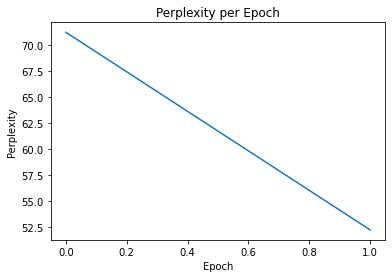

In [155]:
# Hyperparameters for contructing the encoder-decoder model.
embed_size = 256   # Each word will be represented as a `embed_size`-dim vector.
hidden_size = 256  # RNN hidden size.
dropout = 0.2

pure_seq2seq = EncoderDecoder(
  encoder=Encoder(embed_size, hidden_size, dropout=dropout),
  decoder=Decoder(embed_size, hidden_size, dropout=dropout),
  src_embed=nn.Embedding(len(src_vocab_set), embed_size),
  trg_embed=nn.Embedding(len(trg_vocab_set), embed_size),
  generator=Generator(hidden_size, len(trg_vocab_set))).to(device)

# Start training. The returned `dev_ppls` is a list of dev perplexity for each
# epoch.
#TODO@ABBY FIX THIS MAKE BIGGER WHEN NO DEBUG
pure_dev_ppls = train(pure_seq2seq, num_epochs=2, learning_rate=1e-3,
                      print_every=100)

# Plot perplexity
lab_utils.plot_perplexity(pure_dev_ppls)

Now, let's train the seq2seq model with attention.

Epoch 0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch Step: 0 Loss: 174.313354
Epoch Step: 100 Loss: 97.797432
Epoch Step: 200 Loss: 82.022820
Epoch Step: 300 Loss: 82.155258
Epoch Step: 400 Loss: 70.289207
Epoch Step: 500 Loss: 67.859009
Epoch Step: 600 Loss: 67.797462
Epoch Step: 700 Loss: 70.868988
Epoch Step: 800 Loss: 60.844482
Validation perplexity: 32.377419


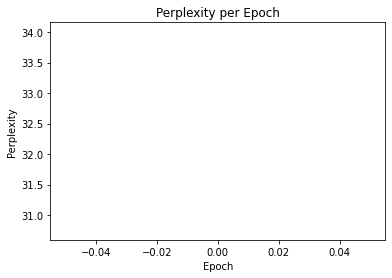

In [156]:
attn_seq2seq = EncoderAttentionDecoder(
  encoder=Encoder(embed_size, hidden_size, dropout=dropout),
  decoder=AttentionDecoder(embed_size, hidden_size,
                  attention=BahdanauAttention(hidden_size), dropout=dropout),
  src_embed=nn.Embedding(len(src_vocab_set), embed_size),
  trg_embed=nn.Embedding(len(trg_vocab_set), embed_size),
  generator=Generator(hidden_size, len(trg_vocab_set))).to(device)

attn_dev_ppls = train(attn_seq2seq, num_epochs=1, learning_rate=1e-3,
                      print_every=100)

lab_utils.plot_perplexity(attn_dev_ppls)

## Section 6: Decoding Algorithms

Now that we have a trained model, the next task is to decode the model output. This is non-trivial. We will first implement a naive, greedy approach, and then we will investigate beam search. You are only required to implement decoding algorithms for the pure_seq2seq model, as a few implementation details will be different if you include Attention. 

1. greedy search
2. beam search (6.864 only, optional for 6.806)

### Greedy Decode

For greedy decoding, we will generate (or "decode") the target sentence by simply taking the argmax on each step of the decoder.

In [157]:
def greedy_decode(model, src_ids, src_lengths, max_len):
  """Greedily decode a sentence for EncoderDecoder. Make sure to chop off the 
     EOS token!"""

  with torch.no_grad():
    _, encoder_finals = model.encode(src_ids, src_lengths)
    prev_y = torch.ones(1, 1).fill_(SOS_INDEX).type_as(src_ids)

  output = []
  hidden = None

  # --------- Your code here --------- #
  for i in range(max_len):
    with torch.no_grad():
      hidden, outputs = model.decode(encoder_finals, prev_y, hidden)
      prob = model.generator(outputs[:, -1])

    d, next_word = torch.max(prob, dim=1)
    next_word = next_word.data.item()
    output.append(next_word)
    prev_y = torch.ones(1, 1).type_as(src_ids).fill_(next_word)

  output = np.array(output)

  # Cut off everything starting from </s>.
  first_eos = np.where(output == EOS_INDEX)[0]
  if len(first_eos) > 0:
    output = output[:first_eos[0]]
  # --------- Your code ends --------- #

  return output


Print the top 3 examples from the data loader by applying the greedy decoder (using the validation dataset).




In [165]:
example_set = MTDataset(val_src_sentences_list, src_vocab_set,
                        val_trg_sentences_list, trg_vocab_set)
example_data_loader = data.DataLoader(example_set, batch_size=1, num_workers=1,
                                      shuffle=False)


lab_utils.print_examples(pure_seq2seq, src_vocab_set, trg_vocab_set,
                         example_data_loader, greedy_decode)

Example #1
Src :  
Trg :  
Pred:  The second of the next year is a very different way .

Example #2
Src :  Tôi muốn cho các bạn biết về sự to lớn của những nỗ lực khoa học đã góp phần làm nên các dòng tít bạn thường thấy trên báo .
Trg :  I &apos;d like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper .
Pred:  I want to tell you about the most important thing that you &apos;re talking about the most important thing to be the most important thing .

Example #3
Src :  Có những dòng trông như thế này khi bàn về biến đổi khí hậu , và như thế này khi nói về chất lượng không khí hay khói bụi .
Trg :  <unk> that look like this when they have to do with climate change , and headlines that look like this when they have to do with air quality or smog .
Pred:  There are the same thing that &apos;s going to be the right now , and it &apos;s not the same thing to do this , and it &apos;s the same thing to do it .



### Beam Search Decode 
Greedy search is easy to implement and fast, but it might not return the optimal translation. We could also try an exhaustive search, but that might take a LONG time. Beam search allows us to constrain the hypothesis search space in a smart way, allowing for greater translation quality while still maintaining a semblance of efficiency.

Students taking 6.806 are only required to do the basic, OG version. Those taking 6.864 must implement the OG version and also normalize by length.

::sidenote
Here's a relevant paper, 'Beam Search Strategies for Neural Machine Translation' [(Freitag and Al-Onaizan 2017)](https://arxiv.org/pdf/1702.01806.pdf) for some newer thoughts.


#### OG Beam

The original beam-search strategy finds a translation that approximately maximizes the conditional probability given by a specific model. It builds the translation from left-to-right and keeps a fixed number (beam) of translation candidates with the highest log-probability at each time step. For each end-of-sequence symbol that is selected among the highest scoring candidates the beam is reduced by one and the translation is stored into a final candidate list. When the beam is zero, it stops the search and picks the translation with the highest log-probability out of the final candidate list.

[Hint: Beam Search with k=1 is the exact same thing as greedy search.]

In [166]:
def og_beam_search(model, src_ids, src_lengths, max_len, beam_width=5):
  """Use beam search to decode a sentence for EncoderDecoder."""

  with torch.no_grad():
    _, encoder_finals = model.encode(src_ids, src_lengths)
    prev_y = torch.ones(1, 1).fill_(SOS_INDEX).type_as(src_ids)

  output = None
  # --------- Your code here --------- #

  # keeps track of the top beam size hypotheses to expand for each element
  # in the batch to be further decoded (that are still "alive")
  new_sequences = [[[], None, prev_y, 0.0]]

  # Give full probability to the first beam on the first step.
  topk_log_probs = [float("-inf") for _ in range(beam_width)]

  # Structure that holds finished hypotheses.
  hypotheses = [[] for _ in range(batch_size)]

  hidden = None

  # walk over each step in sequence
  for i in range(max_len):
    all_candidates = []
    # go through each candidate
    sequences = new_sequences[:]
    for i in range(len(sequences)):
      seq, hidden, prev_y, beam_log_prob = sequences[i]

      # if already at EOS then don't expand more, but keep in running
      if prev_y[0][0] == EOS_INDEX:
        all_candidates.append([seq, hidden, prev_y,beam_log_prob])
        continue

      # expand current candidate and get log_probs
      with torch.no_grad():
        hidden, outputs = model.decode(encoder_finals, prev_y, hidden)
        log_probs = model.generator(outputs[:, -1])

      # multiply probs by the current beam probability (=add logprobs)
      log_probs += beam_log_prob

      # get k best from this beam
      k_probs, k_next_words = torch.topk(log_probs, beam_width, dim=1)
      for m in range(len(k_next_words[0])):
        next_word = k_next_words[0][m]
        next_prob = k_probs[0][m]

        current_seq = seq[:]

        next_word_int = next_word.data.item()
        current_seq.append(next_word_int)
      
        prev_y = torch.ones(1, 1).type_as(src_ids).fill_(next_word_int)
        all_candidates.append([current_seq, hidden, prev_y,next_prob])

    # continue with only only best k
    new_sequences = sorted(all_candidates, key=lambda x: x[-1], reverse=True)[:beam_width]

  # remove </s> from end of each
  output = [np.array(seq[0])[:-1] for seq in new_sequences]
  # --------- Your code ends --------- #

  return output

lab_utils.print_examples(pure_seq2seq, src_vocab_set, trg_vocab_set,
                         example_data_loader, og_beam_search, beam_width=3)

Example #1
Src :  
Trg :  
Pred #1:  Now , let &apos;s take a look at the bottom .
Pred #2:  Now , let &apos;s take a look at the top of the world .
Pred #3:  Now , let &apos;s take a look at the top of the brain .

Example #2
Src :  Tôi muốn cho các bạn biết về sự to lớn của những nỗ lực khoa học đã góp phần làm nên các dòng tít bạn thường thấy trên báo .
Trg :  I &apos;d like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper .
Pred #1:  I want to tell you about the most important part of the world , because the most important part of the world is .
Pred #2:  I want to tell you about the most important part of the world , because the most important part of the world is really .
Pred #3:  I want to tell you about the most important part of the world , because the most important part of the world is really quite .

Example #3
Src :  Có những dòng trông như thế này khi bàn về biến đổi khí hậu , và như thế này khi nói về

#### Beam Extensions

Beam has many issues. One is that longer hypotheses have lower scores.

* **Length normalization:** length_penalty(Y)=(5+|Y|)^α/(5+1)^α where |Y| is the current hypothesis length and α is the length normalization coefficient (as defined in [Wu et al. 2016](https://arxiv.org/abs/1609.08144)).
* **End of sentence normalization:** eos_penalty(X,Y)= γ *|X|/|Y| where |X| is the source length, |Y| is the current target length and γ is the end of sentence normalization coefficient
* **Hypothesis Filtering:** drop hypothesis with more X unknown words 






In [ ]:
def beam_plus_search(model, src_ids, src_lengths, max_len, beam_width=5):
  """Use beam search to decode a sentence for EncoderDecoder."""
  #TODO if desired
  return None

lab_utils.print_examples(pure_seq2seq, src_vocab_set, trg_vocab_set, 
                         example_data_loader, beam_plus_search, beam_width=3)

## Section 7: Testing
Compute the BLEU score. BLEU score is a standard measure to evaluate the translation results. For further details, you can refer to [this](https://en.wikipedia.org/wiki/BLEU) link.

In [ ]:
test_set = MTDataset(test_src_sentences_list, src_vocab_set,
                     test_trg_sentences_list, trg_vocab_set, sampling=1.)
test_data_loader = data.DataLoader(test_set, batch_size=1, num_workers=8,
                                   shuffle=False)

print('BLEU score: %f' % (np.mean(lab_utils.compute_BLEU(pure_seq2seq,
                                                         test_data_loader,
                                                         greedy_decode,
                                                         trg_vocab_set))))

 39%|███▉      | 444/1139 [00:14<00:21, 31.91it/s]